In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d 

from scipy.stats import entropy
from Bio import SeqIO

## Prepare data:

In [2]:
# Natural sequences
merge_ds = pd.read_excel('./Taxonomy_and_convex_hull/data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
merge_ds.shape

(7865, 19)

In [3]:
# merge the two natural sh3 spreadsheets together 
# note: there should be both the 'In training set' and 'MMD z..' columns 
nat_df = pd.read_excel('data/LibraryNatural_Training5299.xls')

full_nat_df = nat_df.merge( 
    merge_ds,
    on='Sequences_unaligned').reset_index(drop = True)

train_full_nat_df = full_nat_df
train_full_nat_df = train_full_nat_df.drop_duplicates(subset='Sequence_aligned').reset_index(drop = True)
train_full_nat_df.head()

,Sequence_aligned,Sequences_unaligned,RE_norm,Protein Name,DomainName_x,TranscriptID_x,Species_x,Phylogeny_x,orthologous_group_x,DomainNo_x,...,Species_y,Phylogeny_y,Sequences,MMD_z0,MMD_z1,MMD_z2,header_twist,norm_RE,orthologous_group_y,PhyGroup
0,KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...,SKARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKSRDWWMCELV...,-0.175593,Equilibrative nucleoside transporter protein,"TDEL_0F02380_domain_number[3],jgi",3708.0,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,NOG257967_3,3,...,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...,-1.025860,0.236221,-0.425561,4599_jgi||3708||Equilibrative nucleoside trans...,-0.175593,NOG257967_3,Ascomycota
1,TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...,GTGSNKNKVLFAYSKQDADEVSISLRDLVALEAADTGSGWTKIKNL...,0.119790,Cdc42-interacting protein CIP4,"TDEL_0B05220_domain_number[1],jgi",1310.0,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,KOG3565_1,1,...,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...,-0.778632,-0.124500,-0.325014,5418_jgi||1310||Cdc42-interacting protein CIP4...,0.119790,KOG3565_1,Ascomycota
2,SPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNE-EDWFLASNSGKQ...,SSPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNEEKDWFLASNPSS...,NaN,NADPH oxidase,"TDEL_0B03070_domain_number[1],jgi",1095.0,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,KOG4773_1,1,...,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,SPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNE-EDWFLASNSGKQ...,0.179907,0.814722,-0.539496,1008_jgi||1095||NADPH oxidase ||1||4950||Torul...,NaN,KOG4773_1,Ascomycota
3,MGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNEWFIAKPLGGP...,KMGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNYEWFIAKPIG...,0.093978,NADPH oxidase,"TDEL_0B03070_domain_number[2],jgi",1095.0,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,KOG4773_2,2,...,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,MGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNEWFIAKPLGGP...,2.446540,-0.728629,-0.918339,7417_jgi||1095||NADPH oxidase ||2||4950||Torul...,0.093978,KOG4773_2,Ascomycota
4,SNAPKAVALYSFAGEESGDLPFRKGDVITILKKSQDWWTGRVNGRE...,SSNAPKAVALYSFAGEESGDLPFRKGDVITILKKSESQDDWWTGRV...,NaN,Uncharacterized conserved protein,"TDEL_0D02240_domain_number[1],jgi",2467.0,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,COG2930,1,...,Torulaspora delbrueckii,cellular organisms; Eukaryota; Opisthokonta; F...,SNAPKAVALYSFAGEESGDLPFRKGDVITILKKSQDWWTGRVNGRE...,1.010021,-1.265780,0.897857,2361_jgi||2467||Uncharacterized conserved prot...,NaN,COG2930,Ascomycota


In [4]:
# === functional sequences defined by r.e. > 0.5 ===
func_train_full_nat_df = train_full_nat_df[train_full_nat_df.norm_RE > 0.84158931]
# embeddings
func_train_full_nat_z = func_train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

# === nonfunctional sequences definde by r.e. <= 0.5 ===
nonfunc_train_full_nat_df = train_full_nat_df[~(train_full_nat_df.norm_RE > 0.84158931)]
# embeddings
nonfunc_train_full_nat_z = nonfunc_train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

func_train_full_nat_z.shape, nonfunc_train_full_nat_z.shape

((132, 3), (5167, 3))

## Plot Functional embedding (Figure 3D):

Here, we are plotting all of the natural training sequences (5299). The pink points are 132 functional sequences (r.e. > 0.84158931) and  5167 remaining embeddings are blue. 

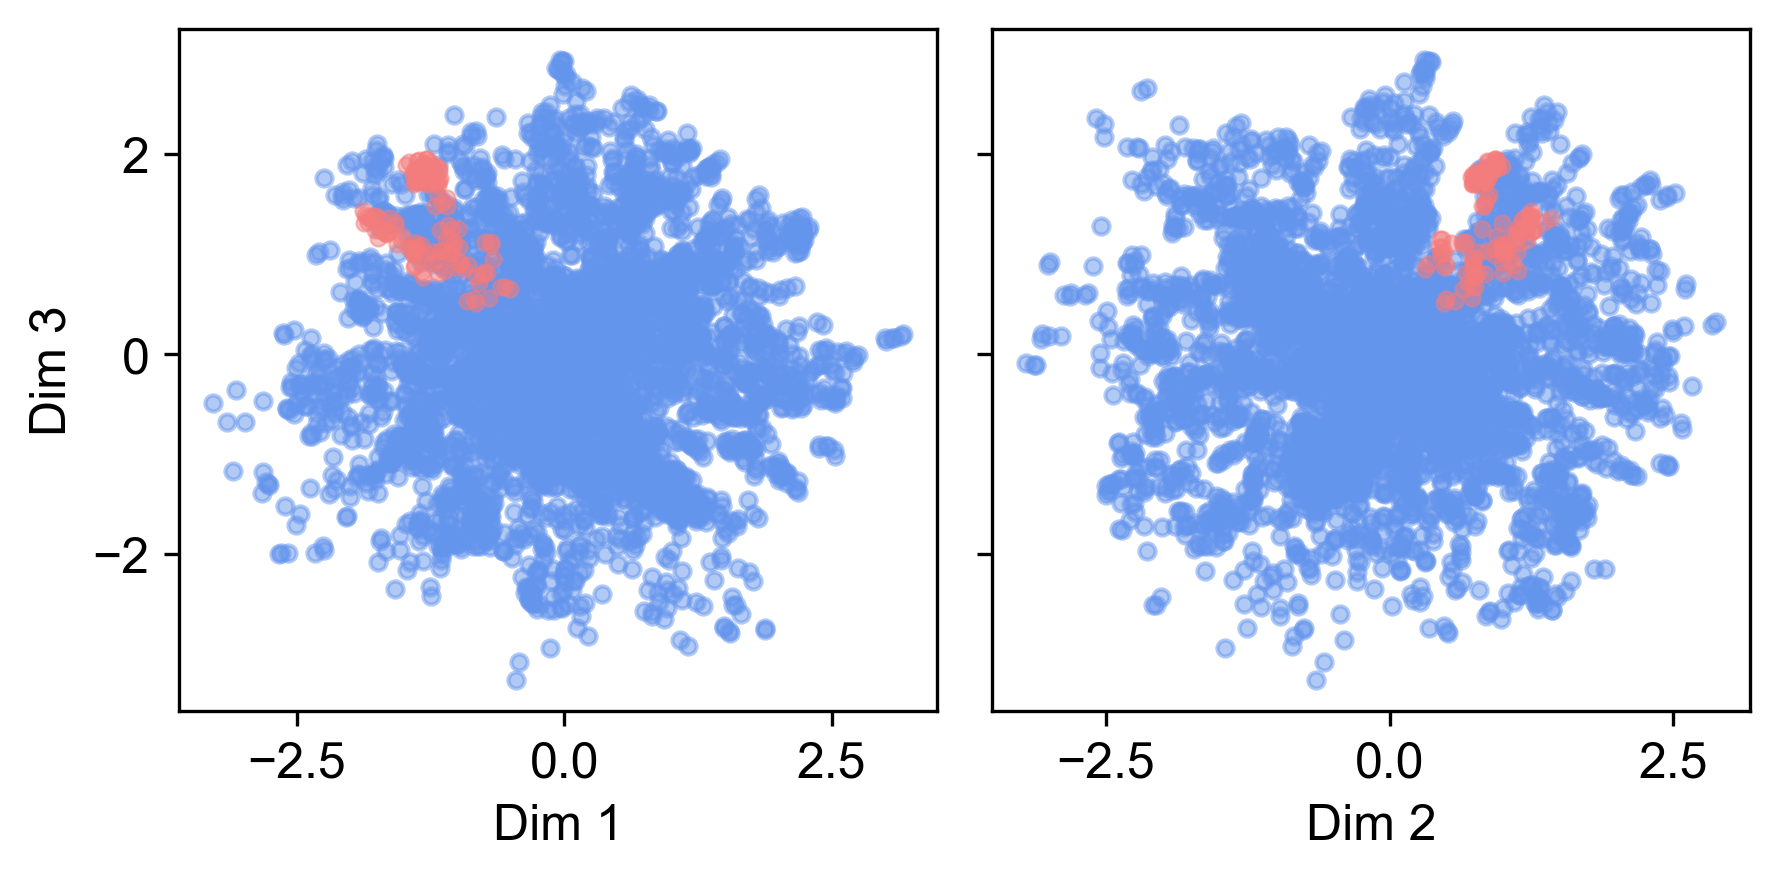

In [5]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams.update({'font.family': 'Arial'})

dsize = 1
size =15
lw=.5
bins = np.linspace(-2.5,2.5,25)

fig, axs = plt.subplots(1, 2, figsize = [6.0,3], sharex="col", sharey="row", dpi=300)


#axs[0, 1].hist(mmd_nat_coord[good_nat,2], bins, orientation='horizontal', color = '#f47b7b')

# functional latent embeddings
axs[0].scatter(nonfunc_train_full_nat_z[:,0], nonfunc_train_full_nat_z[:,2]
               ,s=size, c = 'cornflowerblue',alpha=.5)

axs[0].scatter(func_train_full_nat_z[:,0], func_train_full_nat_z[:,2],
              c = '#f47c7c', linewidth=lw,s = size,alpha=.5 )

# nonfunctional latent embeddings
axs[1].scatter(nonfunc_train_full_nat_z[:,1], nonfunc_train_full_nat_z[:,2]
                                          ,s=size, c = 'cornflowerblue',alpha=.5)
axs[1].scatter(func_train_full_nat_z[:,1], func_train_full_nat_z[:,2],
              c = '#f47c7c', linewidth=lw,s = size,alpha=.5)

# subplot 0 ticks
axs[0].set_xticks([-2.5, 0, 2.5])
axs[0].set_yticks([-2, 0, 2])

# subplot 1 ticks
axs[1].set_xticks([-2.5, 0, 2.5])
axs[1].set_yticks([-2, 0, 2])
    
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 3')
axs[1].set_xlabel('Dim 2')


plt.tight_layout(pad=.8)
#plt.savefig('./figures/Fig3D_natural_func_embeddings.svg', dpi = 300)
plt.show()

## Distances

In [6]:
from scipy.spatial.distance import cdist, squareform

def one_hot_encode_sequences(seqs):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY-"
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}

    one_hot_encoded = np.zeros((len(seqs), len(seqs[0]), len(amino_acids)), dtype=np.uint8)

    for i, seq in enumerate(seqs):
        for j, aa in enumerate(seq):
            one_hot_encoded[i, j, aa_to_idx[aa]] = 1

    return one_hot_encoded.reshape(len(seqs), -1)

In [7]:
seqs = full_nat_df.Sequences
nat_z = train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

In [9]:
# Compute pairwise Hamming distances using one-hot encoding and matrix multiplication
one_hot_seqs = one_hot_encode_sequences(seqs)
pairwise_hamming = len(seqs[0]) - one_hot_seqs @ one_hot_seqs.T

# Compute pairwise Euclidean distances
pairwise_euclidean = cdist(nat_z, nat_z, metric='euclidean')

# Filter out the diagonal elements (distance to self)
hamming_mask = np.eye(pairwise_hamming.shape[0], dtype=bool)
hamming_no_diag = pairwise_hamming[~hamming_mask]
pairwise_euclidean = pairwise_euclidean[~hamming_mask]

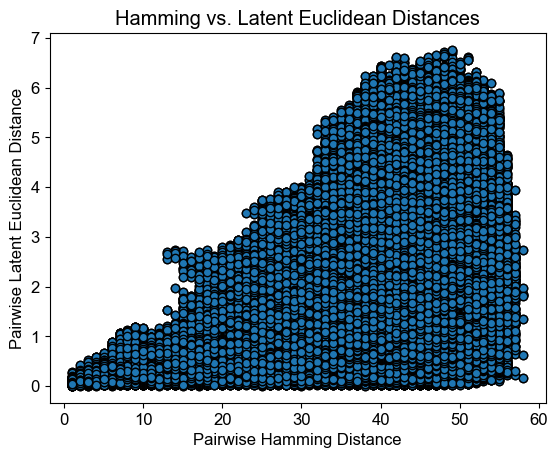

In [11]:
# Plot Hamming vs. Euclidean distances
plt.scatter(hamming_no_diag, pairwise_euclidean, edgecolor = 'k')
plt.xlabel("Pairwise Hamming Distance")
plt.ylabel("Pairwise Latent Euclidean Distance")
plt.title("Hamming vs. Latent Euclidean Distances")
plt.show()